##### EDA

In [2]:
import pandas as pd

# Sample DataFrame
data = {'ID': [1, 2, 3, 4, 5, 6, 7],
        'Col1': ['A', 'B', 'C', 'A', 'D', 'E', 'C'],
        'Col2': [10, 20, 30, 10, 40, 50, 30],
        'Col3': [True, False, True, True, True, False, True],
        'Col4': [1.1, 2.2, 3.3, 1.1, 4.4, 5.5, 3.3],
        'Col5': ['X', 'Y', 'Z', 'X', 'W', 'V', 'Z'],
        'Col6': ['a', 'b', 'c', 'a', 'd', 'e', 'c']}

df = pd.DataFrame(data)

# Concatenate all columns except 'ID' into a single string
df['concatenated'] = df.apply(lambda row: ''.join(row[['Col1', 'Col2', 'Col3', 'Col4', 'Col5', 'Col6']].astype(str)), axis=1)

# Group by the primary key 'concatenated' and count occurrences
grouped_df = df.groupby('concatenated').size().reset_index(name='Count')

# Merge the grouped DataFrame with the original DataFrame to get the count for each row
df = df.merge(grouped_df, on='concatenated')

# Drop duplicate rows based on the 'ID' column, keeping the first occurrence
df_unique = df.drop_duplicates(subset='concatenated', keep='first')
print(df_unique)

   ID Col1  Col2   Col3  Col4 Col5 Col6   concatenated  Count
0   1    A    10   True   1.1    X    a   A10True1.1Xa      2
1   2    B    20  False   2.2    Y    b  B20False2.2Yb      1
2   3    C    30   True   3.3    Z    c   C30True3.3Zc      2
4   5    D    40   True   4.4    W    d   D40True4.4Wd      1
5   6    E    50  False   5.5    V    e  E50False5.5Ve      1


#### Approacch 1

In [19]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from scipy.stats import randint

In [38]:
randint(2, 10)

In [20]:
# Step 1: Generate a synthetic multiclass dataset
X, y = make_classification(
    n_samples=1000, n_features=20, n_classes=3, n_informative=10, random_state=42
)

# Binarize the labels for ROC (needed for multiclass)
y_bin = label_binarize(y, classes=[0, 1, 2])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=42)

In [35]:
# Step 2: Define the RandomForestClassifier and hyperparameter grid for RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)
param_dist = {
    "n_estimators": randint(50, 200),  # Number of trees
    "max_depth": randint(3, 20),  # Maximum tree depth
    "min_samples_split": randint(2, 10),  # Minimum samples for a split
    "min_samples_leaf": randint(1, 10),  # Minimum samples for a leaf
}

# Step 3: Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Number of random configurations
    cv=3,  # 3-fold cross-validation
    scoring="roc_auc_ovr",  # Optimize for ROC-AUC
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit on the entire training data
random_search.fit(X_train, y_train)

# Access the best parameters and estimator
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

# Step 4: Wrap RandomizedSearchCV with OneVsRestClassifier
ovr_model = OneVsRestClassifier(random_search)

# Fit the One-vs-Rest model with RandomizedSearchCV
ovr_model.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 99}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


OneVsRestClassifier(estimator=RandomizedSearchCV(cv=3,
                                                 estimator=RandomForestClassifier(random_state=42),
                                                 n_iter=20, n_jobs=-1,
                                                 param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13415b250>,
                                                                      'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1340229d0>,
                                                                      'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1341d9990>,
                                                                      'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1331dd250>},
                                                 random_state=42,
                                                 scoring='roc_auc_ovr',
                                                 verbose=1))

In [22]:
ovr_model.estimator

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1101e4690>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x134098790>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1331fd390>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x133789950>},
                   random_state=42, scoring='roc_auc_ovr', verbose=1)

In [23]:
models = ovr_model.estimators_
models

[RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                    n_iter=20, n_jobs=-1,
                    param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13402a450>,
                                         'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1337ba910>,
                                         'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13403fa90>,
                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x134033290>},
                    random_state=42, scoring='roc_auc_ovr', verbose=1),
 RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                    n_iter=20, n_jobs=-1,
                    param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13409a990>,
           

In [36]:
from collections import Counter

# Collect the best hyperparameters for each class
all_best_params = [clf.best_params_ for clf in ovr_model.estimators_]

# Display the best parameters for each class
for i, params in enumerate(all_best_params):
    print(f"Best Parameters for class {i}: {params}")

# Aggregate the hyperparameters across all classes
# Count the most common values for each hyperparameter
hyperparameter_counts = {}
for param_dict in all_best_params:
    for key, value in param_dict.items():
        if key not in hyperparameter_counts:
            hyperparameter_counts[key] = []
        hyperparameter_counts[key].append(value)

# Identify the most common value for each hyperparameter
general_best_params = {
    key: Counter(values).most_common(1)[0][0] for key, values in hyperparameter_counts.items()
}

print("\nGeneral Best Hyperparameters (based on majority voting):")
print(general_best_params)

Best Parameters for class 0: {'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 102}
Best Parameters for class 1: {'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 102}
Best Parameters for class 2: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 99}

General Best Hyperparameters (based on majority voting):
{'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 102}


In [15]:
from sklearn.metrics import accuracy_score

In [31]:
print(X_test.shape)
print(y_test.shape)

(300, 20)
(300, 3)


In [28]:
n_classes

3

In [33]:
# Access individual estimators from the OneVsRestClassifier
all_estimators = ovr_model.estimators_

# Evaluate models and select the best-performing one
best_auc = 0
best_model = None
best_class = None

for class_idx, estimator in enumerate(all_estimators):
    # Get validation predictions for the current class
    y_val_proba = estimator.predict_proba(X_val)[:, 1]  # Probabilities for the positive class
    y_true = (y_val == class_idx).astype(int)  # Binary labels for this class

    # Compute ROC-AUC for the current model
    auc = roc_auc_score(y_true, y_val_proba)

    print(f"Class {class_idx} - ROC-AUC: {auc:.3f}")

    # Track the best model
    if auc > best_auc:
        best_auc = auc
        best_model = estimator
        best_class = class_idx

# Display the best model and its class
print(f"\nBest Model is for Class {best_class} with ROC-AUC: {best_auc:.3f}")


NameError: name 'X_val' is not defined

In [37]:
# Train a RandomForestClassifier with the general best hyperparameters
best_rf = RandomForestClassifier(
    n_estimators = general_best_params['n_estimators'],
    max_depth = general_best_params['max_depth'],
    min_samples_split = general_best_params['min_samples_split']
)

# Train on the full dataset
best_rf.fit(X_train, y_train)

# Predict probabilities and classes on the test set
y_pred_proba = best_rf.predict_proba(X_test)  # Probability predictions
y_pred_class = best_rf.predict(X_test)  # Class predictions

# Print predictions (optional)
print("Predicted Class Probabilities:")
print(f"y_pred_proba.shape: {len(y_pred_proba), len(y_pred_proba[0])}")
print(y_pred_proba[0][:5])  # Display first 5 probabilities

print("\nPredicted Classes:")
print(y_pred_class[:5])  # Display first 5 class predictions

# Calculate accuracy (or other metrics as needed)
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred_class.argmax(axis=1))  # For multiclass
print(f"\nAccuracy: {accuracy:.2f}")

Predicted Class Probabilities:
y_pred_proba.shape: (3, 300)
[[0.76979127 0.23020873]
 [0.83618808 0.16381192]
 [0.81641825 0.18358175]
 [0.87906162 0.12093838]
 [0.77896825 0.22103175]]

Predicted Classes:
[[0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]]

Accuracy: 0.76


In [17]:
# Plot ROC Curve for each class
n_classes = y_test.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[0][:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with General Best Parameters")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Predicted Class Probabilities:
[[0.83549692 0.16450308]
 [0.72581819 0.27418181]
 [0.82309227 0.17690773]
 [0.88895497 0.11104503]
 [0.81228744 0.18771256]]

Predicted Classes:
[[0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]]

Accuracy: 0.75


IndexError: index 2 is out of bounds for axis 1 with size 2

In [4]:
# Display the best parameters
# Access the best_params_ from the RandomizedSearchCV inside the OneVsRestClassifier
best_params = ovr_model.estimator.best_params_
print("Best Hyperparameters:", best_params)

# Step 5: Predict probabilities for the test set
y_pred_proba = ovr_model.predict_proba(X_test)

# Step 6: Plot ROC curves for each class
n_classes = y_bin.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f"Class {i} (AUC = {roc_auc[i]:.2f})",
    )

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")

# Add labels, legend, and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multiclass (One-vs-Rest with RandomizedSearchCV)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

### Approach 2

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate synthetic multiclass data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=3, n_informative=10, random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Wrap it in OneVsRestClassifier
ovr = OneVsRestClassifier(rf)

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    "estimator__n_estimators": [50, 100, 200],
    "estimator__max_depth": [None, 10, 20, 30],
    "estimator__min_samples_split": [2, 5, 10],
    "estimator__min_samples_leaf": [1, 2, 4],
}

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    ovr, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=3, random_state=42, n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 30}
Best Score: 0.7814093393492536


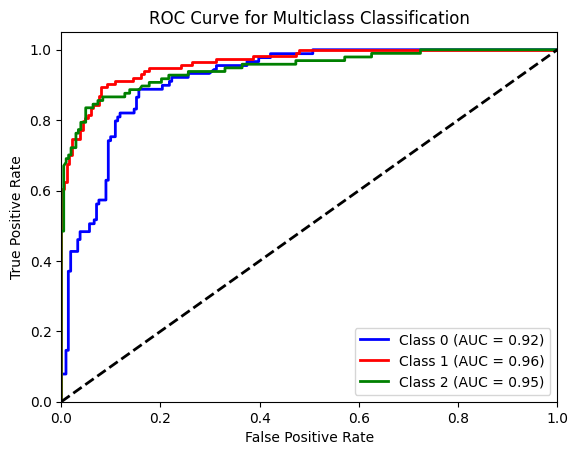

In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Predict probabilities
y_score = random_search.best_estimator_.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()